1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


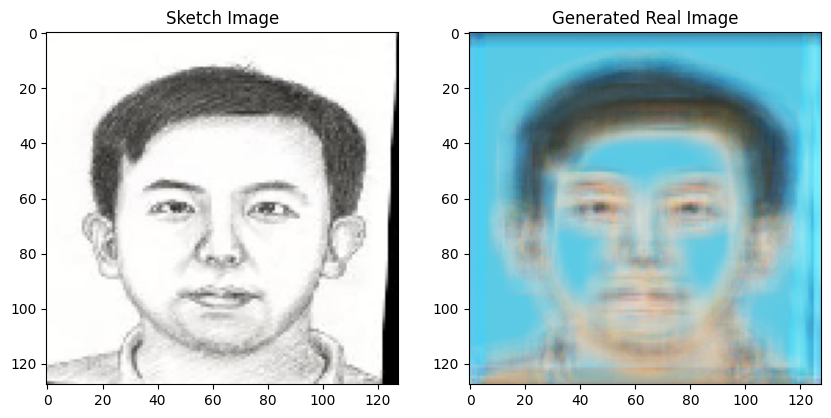

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/trained_model.h5')

# Define image size and preprocessing functions
IMG_SIZE = (128, 128)

def preprocess_image(image_path, img_size):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def display_results(sketch_img, generated_img):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Sketch Image')
    plt.imshow(np.squeeze(sketch_img))  # Remove batch dimension and show

    plt.subplot(1, 2, 2)
    plt.title('Generated Real Image')
    plt.imshow(np.squeeze(generated_img))  # Remove batch dimension and show

    plt.show()

def generate_real_image(sketch_image_path, save_path):
    # Preprocess the sketch image
    sketch_img = preprocess_image(sketch_image_path, IMG_SIZE)

    # Generate the real image
    generated_img = model.predict(sketch_img)

    # Save the generated image
    save_img(save_path, np.squeeze(generated_img))

    # Display results
    display_results(sketch_img, generated_img)

# Example usage
generate_real_image('/content/m-100-01-sz1.jpg', '/content/generated_image.jpg')


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.metrics import structural_similarity as ssim

# Define image size and preprocessing functions
IMG_SIZE = (128, 128)

def preprocess_image(image_path, img_size):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array

def calculate_ssim(img1_path, img2_path, img_size, win_size=7):
    # Preprocess the images
    img1 = preprocess_image(img1_path, img_size)
    img2 = preprocess_image(img2_path, img_size)

    # Ensure the images have the same shape
    assert img1.shape == img2.shape, "Images must have the same shape for SSIM calculation"

    # Compute SSIM
    ssim_value = ssim(img1, img2, win_size=win_size, channel_axis=-1, data_range=1.0)

    return ssim_value

# Paths to the images
generated_image_path = '/content/generated_image.jpg'
reference_image_path = '/content/m-100-01.jpg'

# Calculate SSIM
ssim_value = calculate_ssim(generated_image_path, reference_image_path, IMG_SIZE)
print(f"SSIM between the generated and reference images: {ssim_value:.4f}")


SSIM between the generated and reference images: 0.4242


In [ ]:
import zipfile
import os

# Specify the path to your ZIP file
zip_file_path = '/content/datasets.zip'  # Change this to your ZIP file path
extract_folder = '/content/'  # Folder to extract to

# Create a folder to extract files
os.makedirs(extract_folder, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f'Files extracted to: {extract_folder}')


Files extracted to: /content/


In [ ]:
import os
import re
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import layers, models


In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

photos_path = '/content/datasets/photos'
sketches_path= '/content/datasets/sketches'


sketch_file = sorted_alphanumeric(os.listdir(sketches_path))
image_file= sorted_alphanumeric(os.listdir(photos_path))



In [ ]:
IMG_SIZE = (128, 128)  # Adjust according to your dataset
BATCH_SIZE = 32


In [ ]:
def load_images_from_folder(folder, img_size):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)


In [ ]:
sketch_images = load_images_from_folder(sketches_path, IMG_SIZE)
photo_images = load_images_from_folder(photos_path, IMG_SIZE)


In [ ]:
def split_data(images, split_ratio=0.8):
    num_images = len(images)
    split_index = int(num_images * split_ratio)
    return images[:split_index], images[split_index:]

sketch_train, sketch_val = split_data(sketch_images)
photo_train, photo_val = split_data(photo_images)


In [ ]:
def create_model():
    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = layers.Conv2D(64, (7, 7), strides=(1, 1), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # Add more layers as needed...

    x = layers.Conv2D(3, (7, 7), padding='same')(x)
    outputs = layers.Activation('sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model


In [ ]:
model = create_model()

history = model.fit(
    sketch_train, photo_train,
    epochs=500,
    batch_size=BATCH_SIZE,
    validation_data=(sketch_val, photo_val)
)


Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 475ms/step - accuracy: 0.3375 - loss: 0.1109 - val_accuracy: 0.4076 - val_loss: 0.0948
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2269 - loss: 0.0802 - val_accuracy: 0.4347 - val_loss: 0.0767
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3257 - loss: 0.0691 - val_accuracy: 0.4386 - val_loss: 0.0787
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.2858 - loss: 0.0696 - val_accuracy: 0.4464 - val_loss: 0.0800
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3797 - loss: 0.0655 - val_accuracy: 0.4534 - val_loss: 0.0782
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.3573 - loss: 0.0643 - val_accuracy: 0.4542 - val_loss: 0.0797
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3697 - loss: 0.0639 - val_accuracy: 0.4577 - val_loss: 0.0803
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3482 - loss: 0.0652 - val_accuracy: 0.4650 - val_loss

In [ ]:
model.evaluate(sketch_val, photo_val)

model.save('/content/trained_model.h5')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5183 - loss: 0.1552


In [ ]:
import zipfile
import os

zip_file_path = '/content/datasets.zip'  # Change this to your zip file name
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')  # Change the path as needed


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import RMSprop
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import time
import os
import re
import glob
from PIL import Image
from tensorflow import keras
from keras import optimizers
optimizer=keras.optimizers.Adam(learning_rate=0.001)



In [ ]:
import os
import re
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Defining the size of the image
SIZE = 256
image_path = '/kaggle/input/person-face-sketches/train/photos'
img_array = []

sketch_path = '/kaggle/input/person-face-sketches/train/sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))

# Define a function to perform augmentation
def augment_image(image):
    augmented_images = []
    # Normal image
    augmented_images.append(img_to_array(image))

    # Horizontal flip
    img1 = cv2.flip(image, 1)
    augmented_images.append(img_to_array(img1))

    # Vertical flip
    img2 = cv2.flip(image, 0)
    augmented_images.append(img_to_array(img2))

    # Rotate clockwise
    img3 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    augmented_images.append(img_to_array(img3))

    # Rotate clockwise and then flip horizontally
    img4 = cv2.flip(img3, 1)
    augmented_images.append(img_to_array(img4))

    # Rotate counterclockwise
    img5 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    augmented_images.append(img_to_array(img5))

    # Rotate counterclockwise and then flip horizontally
    img6 = cv2.flip(img5, 1)
    augmented_images.append(img_to_array(img6))

    return augmented_images

# Process real images
for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SIZE, SIZE))
    image = image.astype('float32') / 255.0
    img_array.extend(augment_image(image))

# Process sketch images
for i in tqdm(sketch_file):
    sketch = cv2.imread(sketch_path + '/' + i, 1)
    sketch = cv2.cvtColor(sketch, cv2.COLOR_BGR2RGB)
    sketch = cv2.resize(sketch, (SIZE, SIZE))
    sketch = sketch.astype('float32') / 255.0
    sketch_array.extend(augment_image(sketch))

print("Total number of sketch images:", len(sketch_array))
print("Total number of real images:", len(img_array))


 21%|██        | 4312/20655 [00:47<04:26, 61.43it/s]

In [ ]:
print("Total number of sketch image:",len(sketch_array))
print("Total number of real image:",len(img_array))

Total number of sketch image: 1316
Total number of real image: 1316


In [ ]:
#defining function to plot images pair
def plot_image(image,sketches):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('Real Image',color="g",fontsize=20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Sketch Image',color="b",fontsize=20)
    plt.imshow(sketches)
    plt.show()

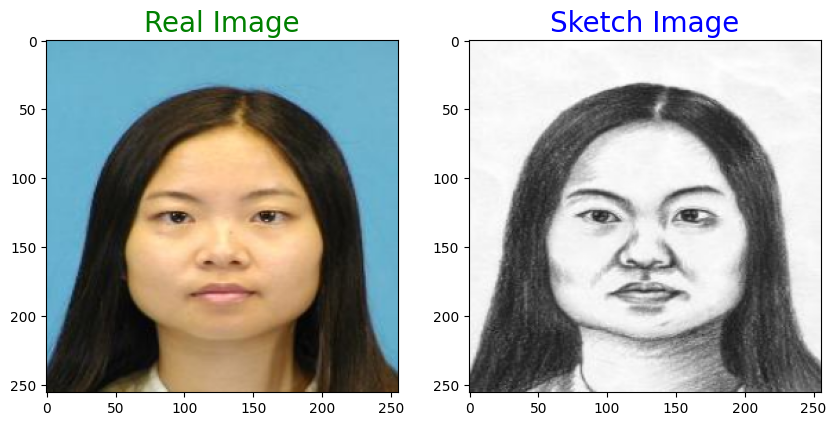

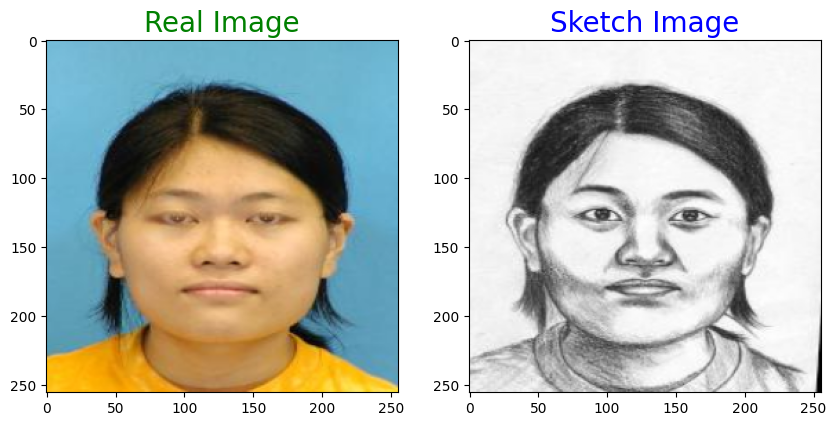

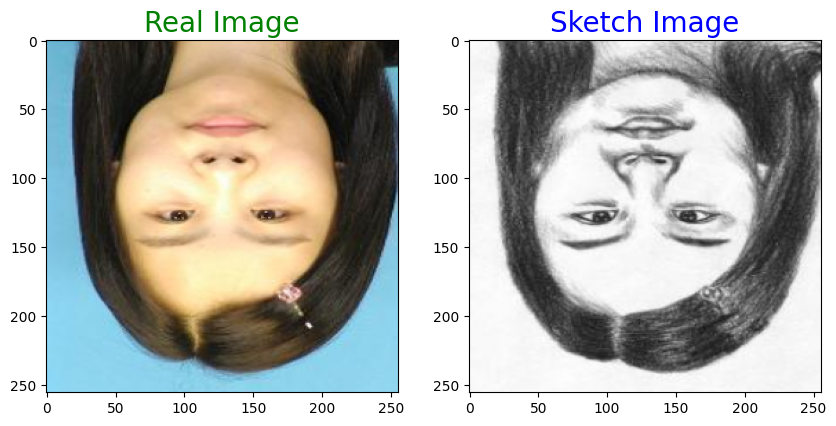

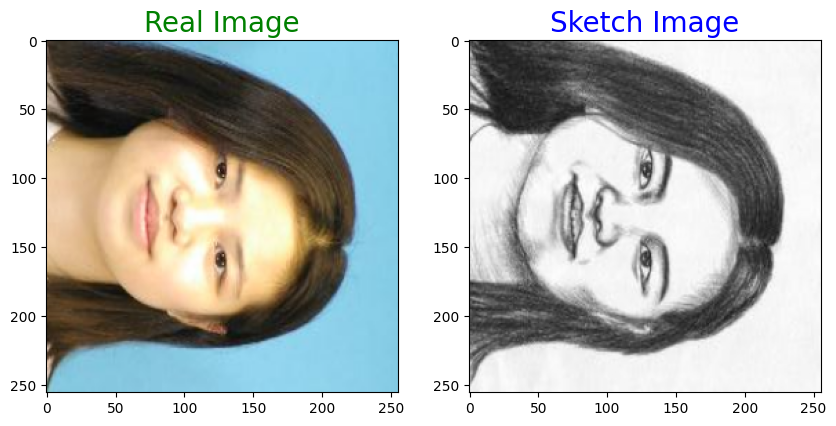

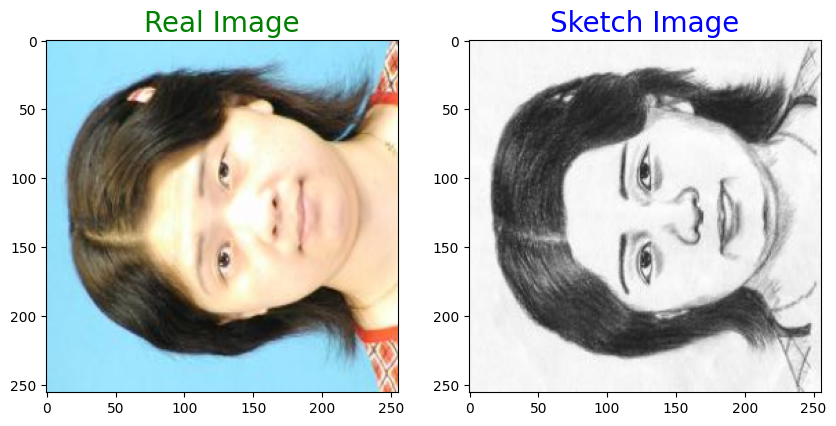

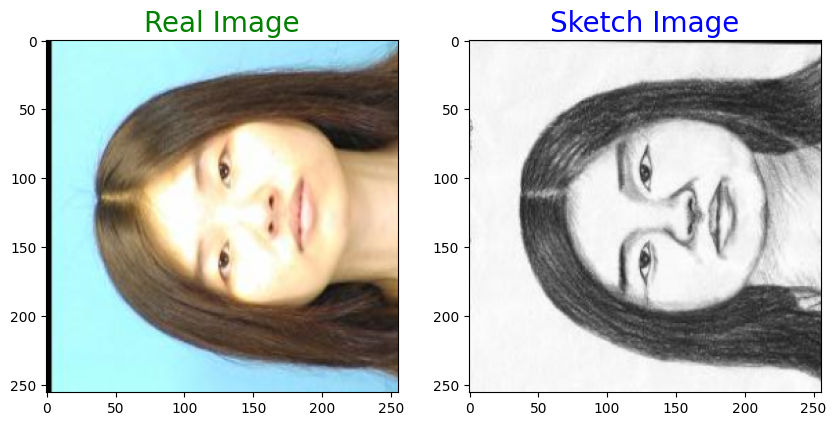

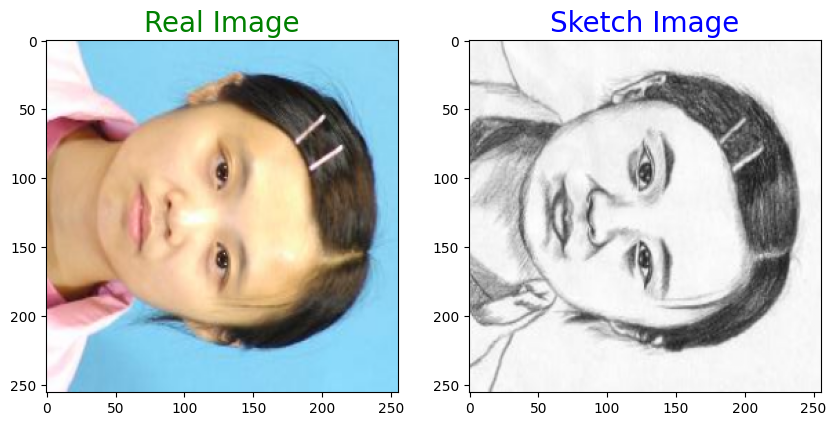

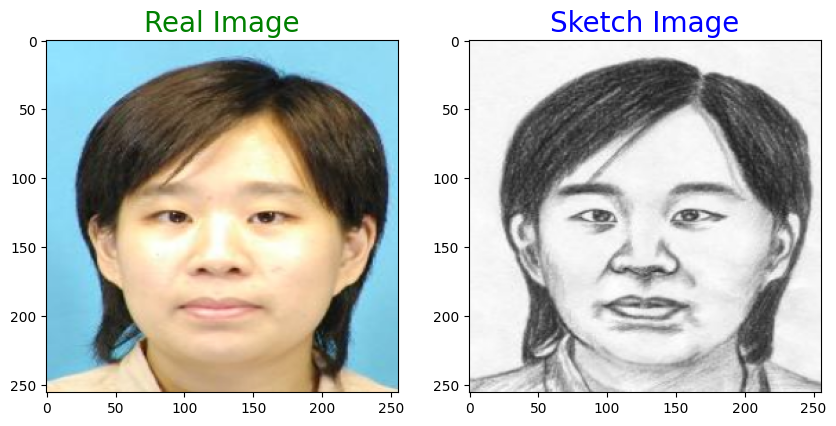

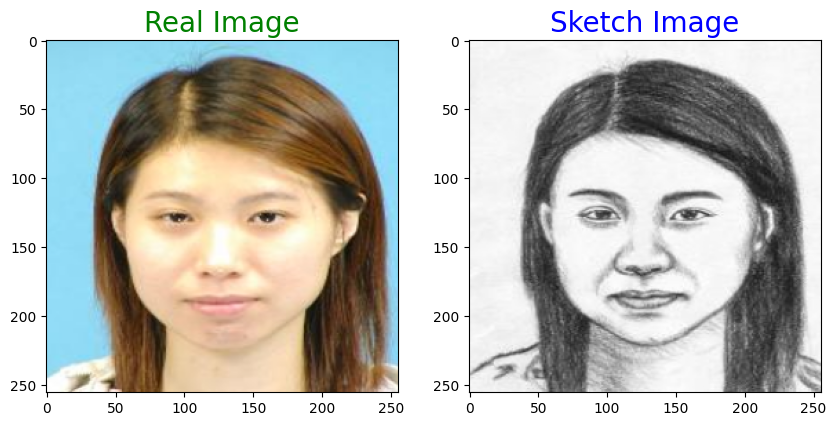

In [ ]:
Is = list(range(0, 65, 8))

# Loop through the indices and plot images
for i in Is:
    plot_image(img_array[i], sketch_array[i])
    time.sleep(1)

In [ ]:
import numpy as np

# Total number of images
total_images = 1316

# Calculate the number of test images (20%)
num_test_images = int(total_images * 0.2)

# Split the data
train_sketch_image = sketch_array[:total_images - num_test_images]
train_image = img_array[:total_images - num_test_images]
test_sketch_image = sketch_array[total_images - num_test_images:]
test_image = img_array[total_images - num_test_images:]

# Reshaping
train_sketch_image = np.reshape(train_sketch_image, (len(train_sketch_image), SIZE, SIZE, 3))
train_image = np.reshape(train_image, (len(train_image), SIZE, SIZE, 3))
print("Train color image shape:", train_image.shape)

test_sketch_image = np.reshape(test_sketch_image, (len(test_sketch_image), SIZE, SIZE, 3))
test_image = np.reshape(test_image, (len(test_image), SIZE, SIZE, 3))
print("Test color image shape:", test_image.shape)


Train color image shape: (1053, 256, 256, 3)
Test color image shape: (263, 256, 256, 3)


In [ ]:
def create_train_sets(sketches,photos):
  X_train =[]
  Y_train =[]
  for i in range(len(sketches)):
    path=sketches[i]
    temp_img=image.load_img(path,target_size=(128,128,3))
    temp_image=image.img_to_array(temp_img)
    X_train.append(temp_img)

  for i in range(len(photos)):
    path=photos[i]
    temp_img=image.load_img(path,target_size=(128,128,3))
    temp_image=image.img_to_array(temp_img)
    Y_train.append(temp_img)

  X_train=np.array(X_train)
  Y_train=np.array(Y_train)

  X_train=X_train.astype('float32')
  Y_train=Y_train.astype('float32')

  X_train=X_train/255.0
  Y_train=Y_train/255.0

  X_train=X_train/255.0
  Y_train=Y_train/255.0

  X_train=X_train*2-1
  Y_train=Y_train*2-1

  return X_train,Y_train
print("Training Complete")

Training Complete


In [ ]:
X_train=[]
Y_train=[]


In [ ]:
def minb_dis(x):
  diffs=K.expand_dims(x,3)-K.expand_dims(K.permute_dimensions(x,[1,2,0]),0)
  abs_diffs=K.sum(K.abs(diffs),axis=2)
  x=K.sum(K.exp(-abs_diffs),axis=2)
  return x
def lambda_output(input_shape):

  return input_shape[:2]

def discriminator(img_dim,nb_patch):
  list_input=[Input(img_dim,name="disc_input_%" % i) for i in range(16)]
  nb_filters=64
  nb_conv=int(np.floor(np.log(img_dim[1])/np.log(2)))
  list_filters=[nb_filters*min(8,(2**i)) for i in range(nb_conv)]

  x_input=Input(img_dim,name="discriminator_input")

  x=Conv2D(list_filters[0],(3,3),strides=(2,2), name="disc_con2d_1",padding="same")(x_input)
  x=BatchNormalization()(x)
  x=LeakyReLU(0.2)(x)

  for i,f in enumerate(list_filters[1:]):
    name="disc_con2d_%s" % (i+2)
    x=Conv2D(f,(3,3),strides=(2,2), name=name,padding="same")(x)
    x=BatchNormalization()(x)
    x=LeakyReLU(0.2)(x)

  x_flat=Flatten()(x)
  x=Dense(2,activation="softmax",name="disc_dense_2")(x_flat)

  PatchGAN=Model(input=[x_input],output=[x,x_flat],name="PatchGAN")

  x=[PatchGAN(patch)[0] for patch in list_input]
  x_mbd=[PatchGAN(patch)[1] for patch in list_input]

  x=merge(x,mode="concat",name="merge_feat")
  x_mbd=merge(x_mbd,mode="concat",name="merge_feat_mbd")

  M=Dense(500,bias=False,activation=None)
  MBD=Lambda(minb_dis,output_shape=lambda_output)

  x_mbd=M(x_mbd)
  x_mbd=Reshape(100,5)(x_mbd)
  x_mbd=MBD(x_mbd)
  x=merge([x,x_mbd],mode="concat")

  x_out=Dense(2,activation="softmax",name="disc_dense_out")(x)

  discriminator=Model(input=list_input,output=x_out,name="DCGAN_discriminator")

  return discriminator_model


for i in tqdm(range(100),desc="loading...",ascii=False,ncols=75):
  time.sleep(0.05)

print("process complete")


loading...: 100%|████████████████████████| 100/100 [00:05<00:00, 19.74it/s]

process complete


In [ ]:
def DCGAN(generator, discriminator_model, img_dim, patch_size):
    gen_input = Input(shape=img_dim, name="DCGAN_input")
    generated_image = generator(gen_input)

    h, w = img_dim[:-1]
    ph, pw = patch_size

    list_row_idx = [(i + 1) * ph for i in range(h // ph)]
    list_col_idx = [(i + 1) * pw for i in range(w // pw)]

    list_gen_patch = []

    for row_idx in list_row_idx:
        for col_idx in list_col_idx:
            x_patch = Lambda(lambda z: z[:, row_idx[0]:row_idx[1], col_idx[0]:col_idx[1], :])(generated_image)
            list_gen_patch.append(x_patch)

    DCGAN_output = discriminator_model(list_gen_patch)
    DCGAN = Model(input=[gen_input], output=[generated_image, DCGAN_output], name="DCGAN")
    return DCGAN

for i in tqdm(range(100),desc="DCGAN...",ascii=False,ncols=75):
  time.sleep(0.10)


print("DCGAN model process complete")


DCGAN...: 100%|██████████████████████████| 100/100 [00:10<00:00,  9.88it/s]

DCGAN model process complete


In [ ]:
def discriminator_loss(y_true, y_pred):
    BATCH_SIZE = 10
    return K.mean(K.binary_crossentropy(K.flatten(y_pred), K.concatenate([K.ones_like(K.flatten(y_pred[:BATCH_SIZE]))], K.zeros_like(K.flatten(y_pred)))), axis=-1)

def mean_squared_error(y_true, y_pred):
    return 10 * K.mean(K.square(y_pred - y_true), axis=-1)

def discriminator_on_generator_loss(y_true, y_pred):
    BATCH_SIZE = 10
    return K.mean(K.binary_crossentropy(K.flatten(y_pred), K.ones_like(K.flatten(y_pred))), axis=-1)

def l1_loss(y_true, y_pred):
    return K.sum(K.abs(y_pred - y_true), axis=-1)


In [ ]:
def getPatch(X, patch_size):
    list_X = []
    list_row_idx = [(i * patch_size[0], (i + 1) * patch_size[0]) for i in range(X.shape[1] / patch_size[0])]
    list_col_idx = [(i * patch_size[1], (i + 1) * patch_size[1]) for i in range(X.shape[2] /  patch_size[1])]

    for row_idx in list_row_idx:
        for col_idx in list_col_idx:
            list_X.append(X[:, row_idx[0]:row_idx[1], col_idx[0]:col_idx[1], :])

    return list_X


In [ ]:

def generator():
    input_shape = (128, 128, 3)
    img_rows, img_cols = 128, 128
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(32, (7, 7), strides=(1, 1), padding="same")(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)

    conv2 = Conv2D(64, (3, 3), strides=(2, 2), padding="same")(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)

    conv3 = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)

    b1 = Conv2D(128, (3, 3), padding="same")(conv3)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3, 3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    block1 = keras.layers.add([b1, b2])

    b1 = Conv2D(128, (3, 3), padding="same")(block1)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3, 3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)

    block2 = keras.layers.add([b1, b2])
    b1 = Conv2D(128, (3, 3), padding="same")(block2)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3, 3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    block3 = keras.layers.add([b1, b2])

    b1 = Conv2D(128, (3, 3), padding="same")(block3)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3, 3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    block4 = keras.layers.add([b1, b2])

    b1 = Conv2D(128, (3, 3), padding="same")(block4)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3, 3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    block5 = keras.layers.add([b1, b2])

    b1 = Conv2D(128, (3, 3), padding="same")(block5)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3, 3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    block6 = keras.layers.add([b1, b2])

    u1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(block6)
    u1 = BatchNormalization()(u1)
    u1 = Activation("relu")(u1)

    u2 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(u1)
    u2 = BatchNormalization()(u2)
    u2 = Activation("relu")(u2)

    conv4 = Conv2D(3, (3, 3), strides=(1, 1), padding="same")(u2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)

    model = Model(inputs=[inputs], outputs=[conv4])
    return model



In [ ]:
def discriminator():

  inputs = Input((128, 128, 3))
  conv1 = Conv2D(64, (4, 4), strides=(2, 2))(inputs)
  conv1 = Activation(LeakyReLU(alpha=0.2))(conv1)

  conv2 = Conv2D(128, (4, 4), strides=(2, 2))(conv1)
  conv2 = BatchNormalization()(conv2)
  conv2 = Activation(LeakyReLU(alpha=0.2))(conv2)

  conv3 = Conv2D(256, (4, 4), strides=(2, 2))(conv2)
  conv3 = BatchNormalization()(conv3)
  conv3 = Activation(LeakyReLU(alpha=0.2))(conv3)

  conv4 = Conv2D(512, (4, 4), strides=(2, 2))(conv3)
  conv4 = BatchNormalization()(conv4)
  conv4 = Activation(LeakyReLU(alpha=0.2))(conv4)

  out = Flatten()(conv4)
  out = Dense(1, activation='sigmoid')(out)

  model = Model(inputs=inputs, outputs=out)

  return model


In [ ]:
def full_model(g,d):
  inputs = Input((128, 128, 3))
  x_generator = g(inputs)
  #merged = concatenate([inputs, x_generator], axis=0)
  d.trainable = False
  x_discriminator = d(x_generator)

  model = Model(inputs=inputs, outputs=[x_generator, x_discriminator])

  return model

def num_patches(output_img_dim=(3, 256, 256), sub_patch_dim=(64, 64)):
    nb_non_overlapping_patches = (output_img_dim[1] / sub_patch_dim[0]) * (output_img_dim[2] / sub_patch_dim[1])
    return int(nb_non_overlapping_patches), patch_disc_img_dim


In [ ]:
num_epochs = 30
batch_size = 30
from keras import backend as K
smooth = 1.

def discriminator_loss(y_true, y_pred):
    batch_size = 30
    return K.mean(K.binary_crossentropy(K.flatten(y_pred), K.concatenate([K.ones_like(K.flatten(y_pred[:batch_size]))], K.zeros_like(K.flatten(y_pred[:batch_size]))), axis=0))

def discriminator_on_generator_loss(y_true, y_pred):
    batch_size = 30
    return K.mean(K.binary_crossentropy(K.flatten(y_true), K.ones_like(K.flatten(y_pred))), axis=-1)

def generator_l1_loss(y_true, y_pred):
    return K.mean(K.abs(K.flatten(y_pred) - K.flatten(y_true)), axis=-1)

def least_absolute_error(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)


In [ ]:
def downsample(filters, size, apply_batch_normalization=True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters=filters, kernel_size=size, strides=2, use_bias=False, kernel_initializer='he normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def upsample(filters, size, apply_dropout=False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters=filters, kernel_size=size, strides=2, use_bias=False, kernel_initializer='he normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU())
    return upsample


In [ ]:
import tensorflow as tf
from tensorflow import keras

def downsample(filters, size, apply_batch_normalization=True):
    downsample = keras.Sequential()
    downsample.add(keras.layers.Conv2D(filters=filters, kernel_size=size, strides=2, use_bias=False, kernel_initializer='he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def upsample(filters, size, apply_dropout=False):
    upsample = keras.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters=filters, kernel_size=size, strides=2, use_bias=False, kernel_initializer='he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    encoder_input = keras.Input(shape=(SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32, 4, False)(x)
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    encoder_output = downsample(512, 4)(x)

    decoder_input = upsample(512, 4, True)(encoder_output)
    x = upsample(256, 4)(decoder_input)
    x = upsample(128, 4, True)(x)
    x = upsample(64, 4)(x)
    x = upsample(32, 4)(x)
    x = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(1, 1), padding='valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3, (2, 2), strides=(1, 1), padding='valid')(x)

    return tf.keras.Model(encoder_input, decoder_output)

# to get summary of model
model_instance = model()
model_instance.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 127, 127, 16)   │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 62, 62, 32)     │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 30, 30, 64)     │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 6, 6, 512)      │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 14, 14, 512)    │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 30, 30, 256)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 62, 62, 128)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 126, 126, 64)   │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 254, 254, 32)   │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 255, 255, 8)    │         1,032 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 256, 256, 3)    │            99 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,204,651 (31.30 MB)

 Trainable params: 8,203,371 (31.29 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - loss: 0.2514 - mean_squared_error: 0.1677
Epoch 2/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.1035 - mean_squared_error: 0.0271
Epoch 3/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0916 - mean_squared_error: 0.0243
Epoch 4/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0857 - mean_squared_error: 0.0235
Epoch 5/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/step - loss: 0.0910 - mean_squared_error: 0.025


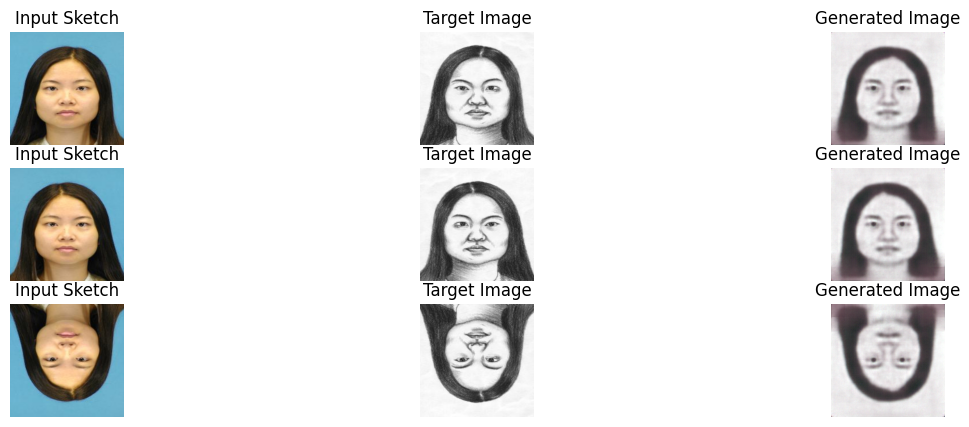

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 0.0909 - mean_squared_error: 0.0249
Epoch 6/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0872 - mean_squared_error: 0.0228
Epoch 7/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0813 - mean_squared_error: 0.0220
Epoch 8/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0795 - mean_squared_error: 0.0213
Epoch 9/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0821 - mean_squared_error: 0.0220
Epoch 10/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/steptep - loss: 0.0762 - mean_squared_error: 0.021


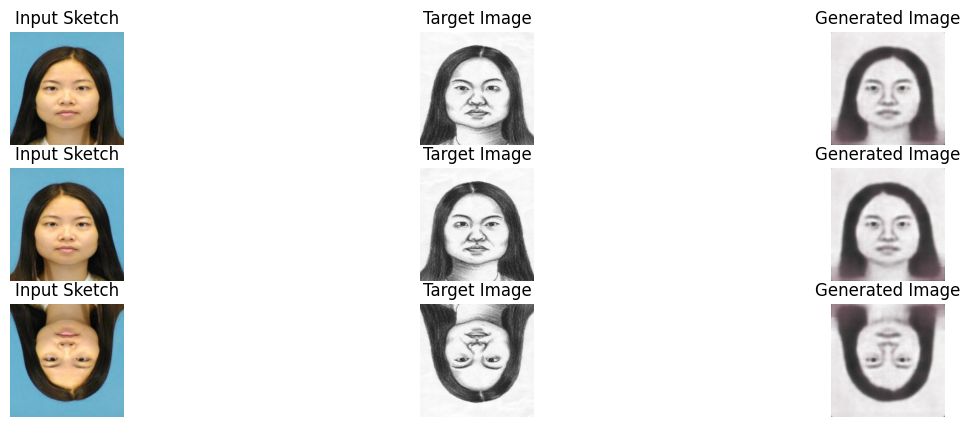

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.0762 - mean_squared_error: 0.0213
Epoch 11/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0774 - mean_squared_error: 0.0211
Epoch 12/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0773 - mean_squared_error: 0.0217
Epoch 13/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0802 - mean_squared_error: 0.0212
Epoch 14/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0767 - mean_squared_error: 0.0211
Epoch 15/16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/steptep - loss: 0.0775 - mean_squared_error: 0.021


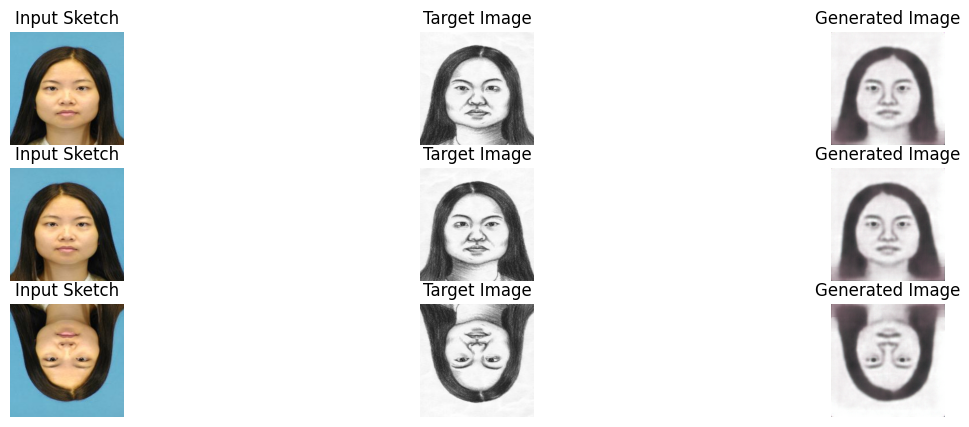

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0775 - mean_squared_error: 0.0218
Epoch 16/16
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0740 - mean_squared_error: 0.0213


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Load the pre-trained model
model_instance = model_instance  # Replace with your model's path

# Define the size of the images
SIZE = 256

# Assuming train_image and train_sketch_image are already defined
# Define a custom callback to display images
class DisplayImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, input_images, target_images):
        super(DisplayImagesCallback, self).__init__()
        self.input_images = input_images
        self.target_images = target_images

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:  # Check if the epoch is a multiple of 5
            # Generate output images
            generated_images = self.model.predict(self.input_images)

            # Display the input, target, and generated images
            plt.figure(figsize=(15, 5))
            for i in range(3):  # Display 3 images
                plt.subplot(3, 3, i * 3 + 1)
                plt.imshow(self.input_images[i])
                plt.title('Input Sketch')
                plt.axis('off')

                plt.subplot(3, 3, i * 3 + 2)
                plt.imshow(self.target_images[i])
                plt.title('Target Image')
                plt.axis('off')

                plt.subplot(3, 3, i * 3 + 3)
                plt.imshow(generated_images[i])
                plt.title('Generated Image')
                plt.axis('off')

            plt.show()

# Compile the model
model_instance.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='mean_absolute_error',
                       metrics=['mean_squared_error'])

# Create an instance of the callback
display_callback = DisplayImagesCallback(train_image[:3], train_sketch_image[:3])  # Display first 3 images

# Fit the model with the callback
model_instance.fit(train_image, train_sketch_image,
                   epochs=16,
                   verbose=1,
                   callbacks=[display_callback])


In [ ]:
prediction_on_test_data = model_instance.predict(test_image,test_sketch_image)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
from keras.preprocessing import image
import cv2
import numpy as np
import glob
import os

#global count = 0

def show_images(sketch, predicted, real, Count):
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 4, 1)
    plt.title("Input Image", fontsize=15, color='Blue')
    plt.imshow(sketch)
    plt.subplot(1, 4, 2)
    plt.title("Target Image", fontsize=15, color='Lime')
    plt.imshow(real)

    img = image.img_to_array(real, dtype='uint8')

    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grey = cv2.medianBlur(grey, 5)
    edges = cv2.adaptiveThreshold(grey, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 9)
    color = cv2.bilateralFilter(real, 9, 250, 250)
    Generate = cv2.bitwise_and(color, color, mask=edges)

    plt.subplot(1, 4, 2)
    plt.title("Generated Image", fontsize=15, color='gold')
    plt.imshow(Generate)

    plt.figure(figsize=(4, 4))
    plt.title("Generated Image", fontsize=15, color='Red')
    plt.imshow(Generate)
    plt.savefig('test/Generate/%d.jpg' % (Count))



In [ ]:
print("Length of test_image:", len(test_image))


Length of test_image: 0


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 38ms/step

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step


<ipython-input-38-6b311928dcb8>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

  plt.figure(figsize=(12, 12))


1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


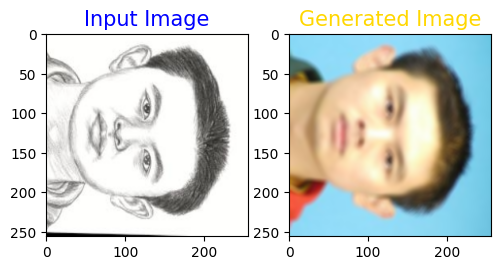

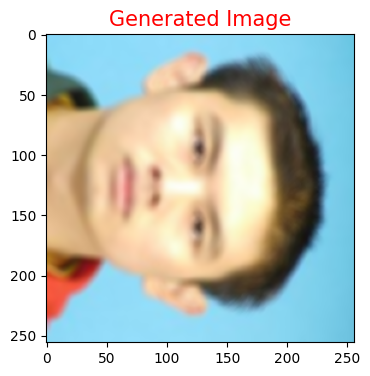

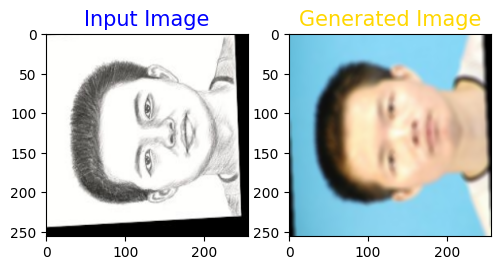

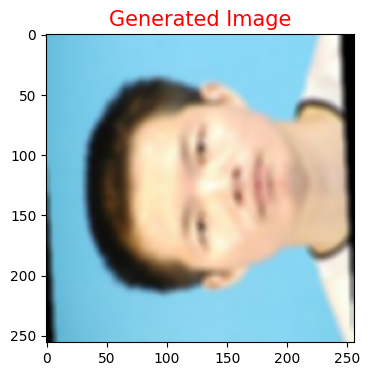

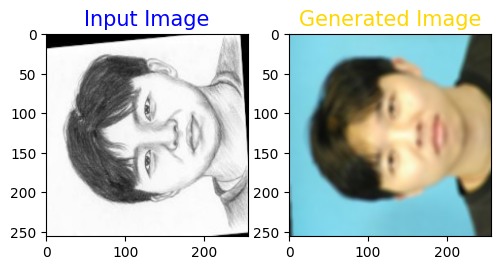

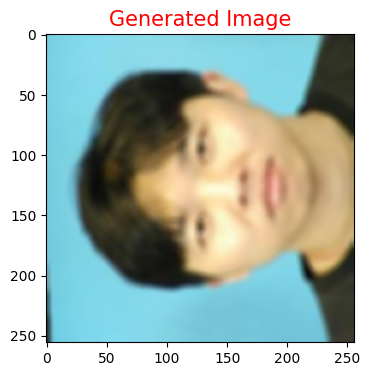

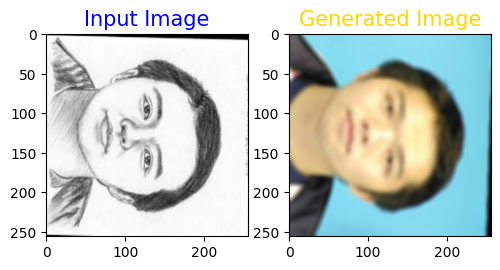

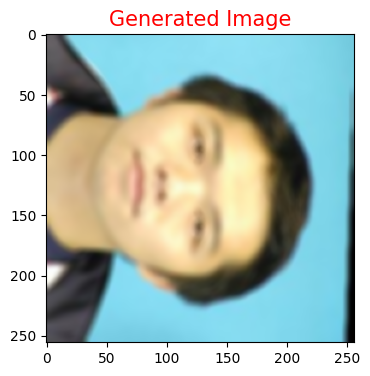

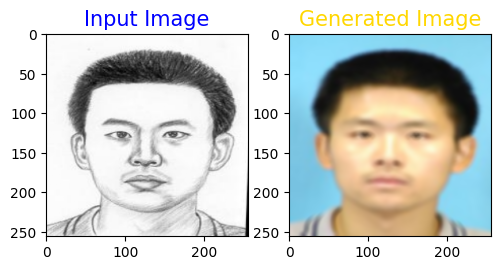

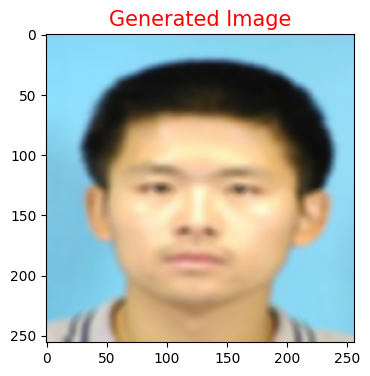

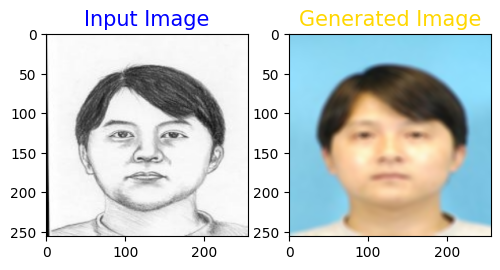

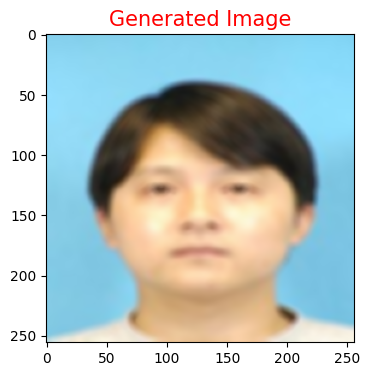

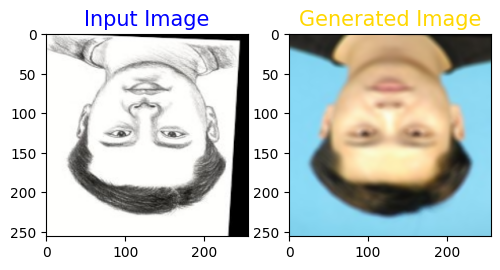

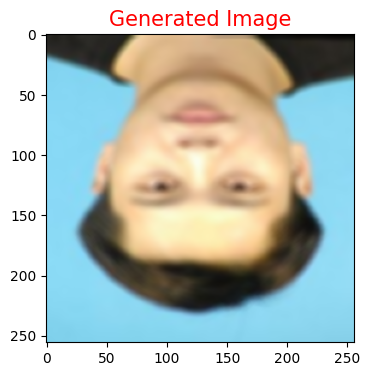

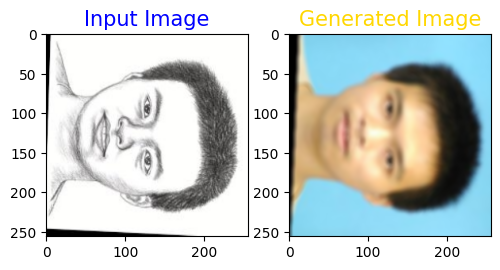

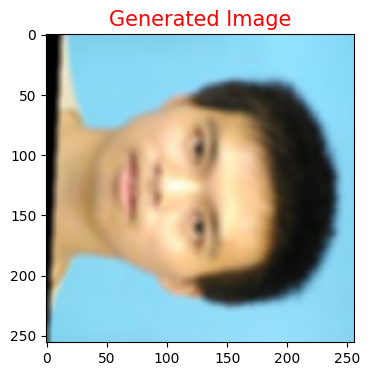

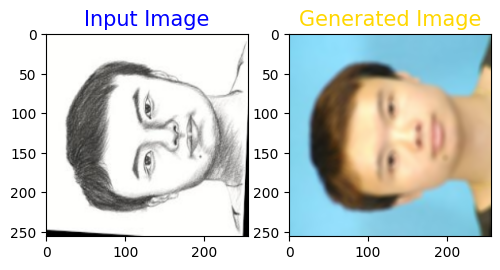

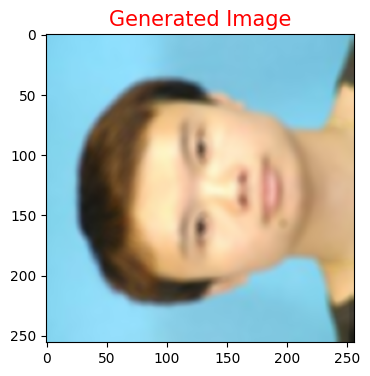

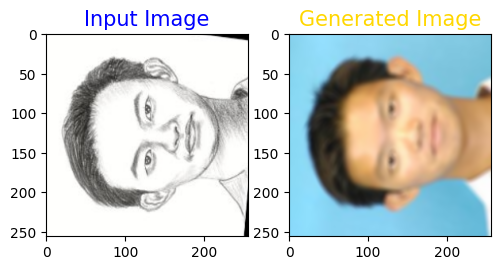

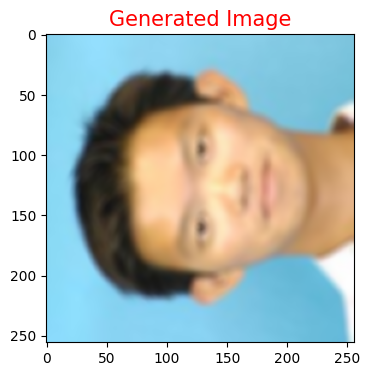

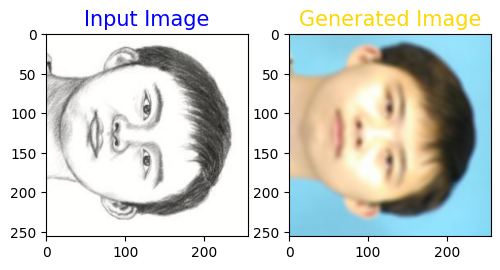

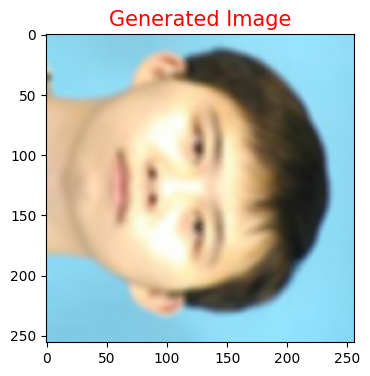

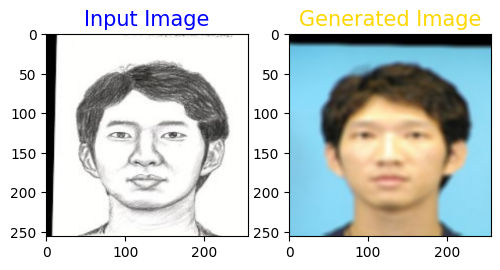

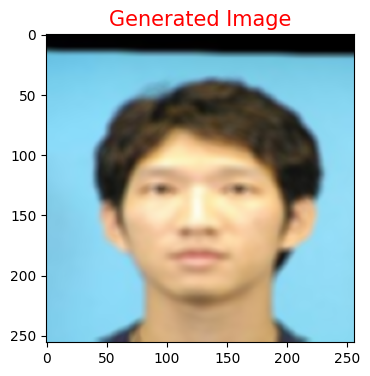

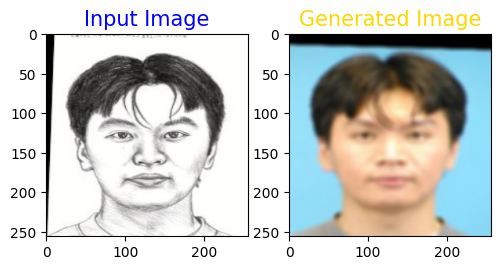

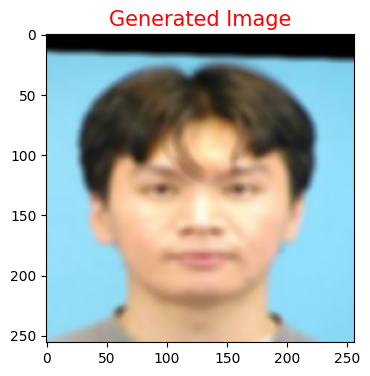

In [ ]:
#global count = 0
ls = [i for i in range(0, 97, 8)]
for i in ls:
    predicted = np.clip(model_instance.predict(test_image[i].reshape(1, SIZE, SIZE, 3)), 0.0, 1.0).reshape(SIZE, SIZE, 3)
    show_images(test_sketch_image[i], predicted, test_image[i], i)
    # cv2.imwrite(f'test/Generate/output_{i}.png', predicted)


In [ ]:
from skimage.metrics import structural_similarity
import natsort

def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles, reverse=False)

def load_images(list_path):
    img_list = list()
    for filename in list_path:
        pixels = cv2.imread(filename)
        img_list.append(pixels)
    return np.asarray(img_list)

def compute_l2(imgs1, imgs2):
    l2_scores = []
    for i in range(len(imgs1)):
        score = (np.square(imgs1[i] - imgs2[i])).mean()
        l2_scores.append(score)
    return np.mean(l2_scores)

def compute_ssim(imgs1, imgs2):
    ssim_scores = []
    for i in range(len(imgs1)):
        grayA = cv2.cvtColor(imgs1[i], cv2.COLOR_BGR2GRAY)
        grayB = cv2.cvtColor(imgs2[i], cv2.COLOR_BGR2GRAY)
        (score, diff) = structural_similarity(grayA, grayB, full=True)
        ssim_scores.append(score)
    return np.mean(score)


In [ ]:
imgs1 = load_images(load_filename("/content/test/Generate/0.jpg"))
imgs2 = load_images(load_filename("/content/test/Generate/16.jpg"))
l2 = compute_l2(imgs1, imgs2)
ssim = compute_ssim(imgs1, imgs2)


NotADirectoryError: [Errno 20] Not a directory: '/content/test/Generate/0.jpg'